In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
data_path = "C:/Users/ahmed/Downloads/web-traffic-time-series-forecasting"

train_1 = pd.read_csv(os.path.join(data_path, "train_1.csv"))

In [4]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [5]:
key_1 = pd.read_csv(os.path.join(data_path, "key_1.csv"))

In [6]:
key_1.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [7]:
key_1.columns

Index(['Page', 'Id'], dtype='object')

In [8]:
train_1.fillna(0, inplace =True)

In [9]:
def extract_details(page):
    sections = page.split('_')
    if len(sections)<3:
        return pd.Series([page, 'unknown', 'unknown', 'unknown'])
    article = '_'.join(sections[:-3])
    language = sections[-3]
    access = sections[-2]
    agent = sections[-1]
    return pd.Series([article, language, access, agent])

In [10]:
train_1[['Article', 'Language', 'Access', 'Agent']] = train_1['Page'].apply(extract_details)

In [11]:
train_1_long = train_1.melt(id_vars=['Page', 'Article', 'Language', 'Access', 'Agent'],
                           var_name = 'Date', value_name = 'Views')

In [12]:
train_1_long['Date'] = pd.to_datetime(train_1_long['Date'])

In [13]:
train_1_long.head()

,Page,Article,Language,Access,Agent,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh.wikipedia.org,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh.wikipedia.org,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,3C,zh.wikipedia.org,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh.wikipedia.org,all-access,spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider,2015-07-01,0.0


In [14]:
train_1_long.sort_values(['Page', 'Date'], inplace=True)

In [15]:
print('Final melted shape: ', train_1_long.shape)

Final melted shape:  (79784650, 7)


In [16]:
train_1_long.head()

,Page,Article,Language,Access,Agent,Date,Views
37206,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access,all-agents,2015-07-01,3.0
182269,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access,all-agents,2015-07-02,4.0
327332,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access,all-agents,2015-07-03,7.0
472395,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access,all-agents,2015-07-04,4.0
617458,!vote_en.wikipedia.org_all-access_all-agents,!vote,en.wikipedia.org,all-access,all-agents,2015-07-05,4.0


In [17]:
train_1_long.to_csv('train_1_preprocessed.csv', index = False)

In [18]:
train_1_long.to_parquet('train_1_preprocessed.parquet', index = False)

In [19]:
train_1_long.head(5000).to_csv('train_preview.csv')

In [20]:
#Vectorised approach

key_1['Page'] = key_1['Page'].astype(str)

#Split the last underscored part form the page name
key_1['Date'] = key_1['Page'].str.rsplit('_', n=1).str[-1]

#Removing the data from page
key_1['Page'] = key_1['Page'].str.rsplit('_', n=1).str[0]

key_1['Date'] = pd.to_datetime(key_1['Date'])

In [21]:
key_1.head()

,Page,Id,Date
0,!vote_en.wikipedia.org_all-access_all-agents,bf4edcf969af,2017-01-01
1,!vote_en.wikipedia.org_all-access_all-agents,929ed2bf52b9,2017-01-02
2,!vote_en.wikipedia.org_all-access_all-agents,ff29d0f51d5c,2017-01-03
3,!vote_en.wikipedia.org_all-access_all-agents,e98873359be6,2017-01-04
4,!vote_en.wikipedia.org_all-access_all-agents,fa012434263a,2017-01-05


Weekly Seasonality

In [22]:
train_1_long['Weekday'] = train_1_long['Date'].dt.day_name()
views_per_week = train_1_long.groupby('Weekday')['Views'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

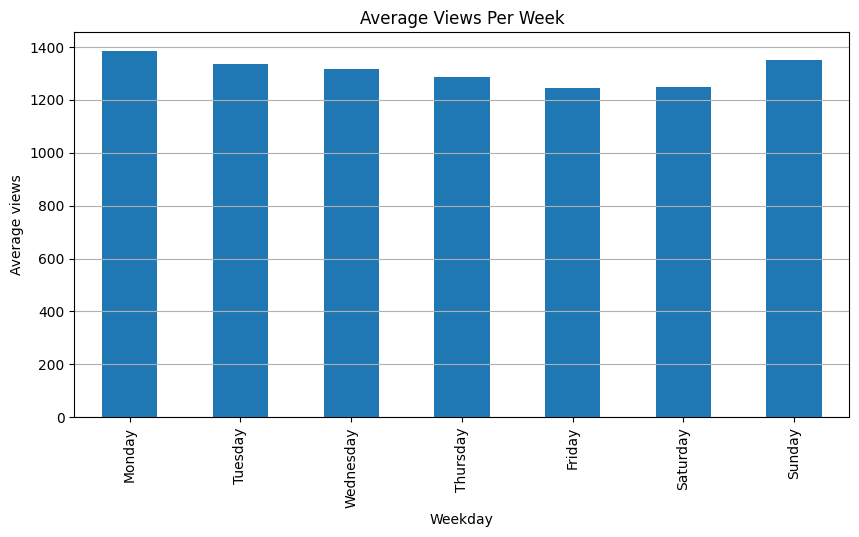

In [23]:
views_per_week.plot(kind = 'bar', figsize=(10, 5), title='Average Views Per Week')
plt.ylabel('Average views')
plt.grid(axis = 'y')
plt.show()

Missing/Zero value

In [24]:
zero_page_views = train_1_long[train_1_long['Views']==0]
print('Total number of Zero page views: ', len(zero_page_views))

#Pages with most zeros
zero_page_count = zero_page_views.groupby('Page').size().sort_values(ascending=False)
print('Pages with most zero view days: ', zero_page_count.head(10))

Total number of Zero page views:  7253349
Pages with most zero view days:  Page
User:46.161.9.22_www.mediawiki.org_all-access_spider                                    550
File:Battle_of_Mosul_(2016–2017).svg_commons.wikimedia.org_all-access_spider            550
Category:Deletion_requests_February_2017_commons.wikimedia.org_all-access_all-agents    550
Category:Deletion_requests_February_2017_commons.wikimedia.org_all-access_spider        550
Category:Deletion_requests_February_2017_commons.wikimedia.org_desktop_all-agents       550
Category:Deletion_requests_January_2017_commons.wikimedia.org_all-access_all-agents     550
Category:Deletion_requests_January_2017_commons.wikimedia.org_all-access_spider         550
Category:Deletion_requests_January_2017_commons.wikimedia.org_desktop_all-agents        550
File:Battle_of_Mosul_(2016–2017).svg_commons.wikimedia.org_all-access_all-agents        550
File:Battle_of_Mosul_(2016–2017).svg_commons.wikimedia.org_desktop_all-agents           550


Distribution of Daily Views

<function matplotlib.pyplot.show(close=None, block=None)>

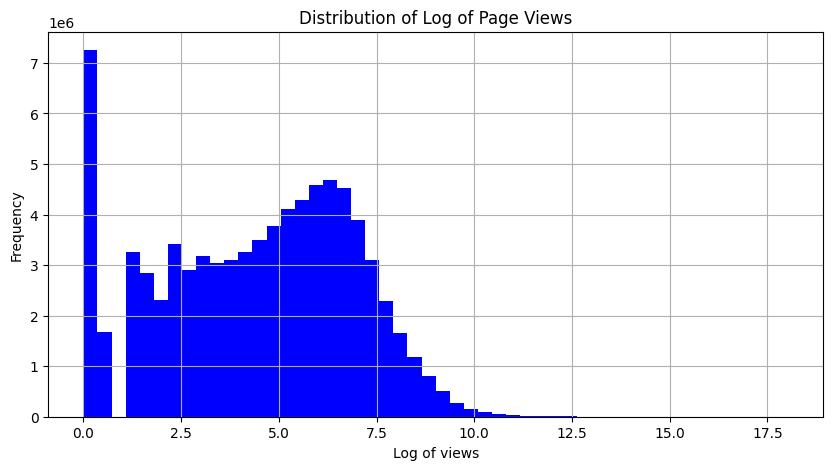

In [25]:
plt.figure(figsize = (10, 5))
plt.hist(np.log1p(train_1_long['Views']), bins=50, color='blue')
plt.title('Distribution of Log of Page Views')
plt.xlabel('Log of views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show

Plotting Single Articles TimeSeries

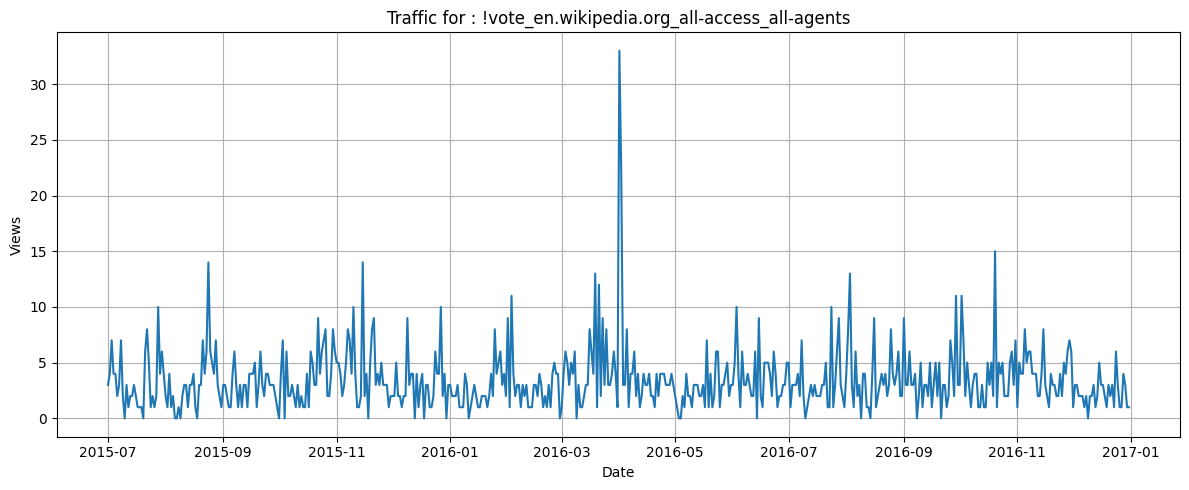

In [26]:
selected_page = train_1_long['Page'].unique()[0]
#filter the page

df_page = train_1_long[train_1_long['Page']==selected_page]

plt.figure(figsize = (12,5))
plt.plot(df_page['Date'], df_page['Views'])
plt.title(f"Traffic for : {selected_page}")
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 and Bottom 10 pages by total views

In [27]:
total_views = train_1_long.groupby('Page')['Views'].sum().sort_values(ascending = False)

top_pages = total_views.head(10)
bottom_pages = total_views.tail(10)

print('Top 10 pages: ', top_pages)
print('Bottom 10 pages: ', bottom_pages)

Top 10 pages:  Page
Main_Page_en.wikipedia.org_all-access_all-agents                      1.206618e+10
Main_Page_en.wikipedia.org_desktop_all-agents                         8.774497e+09
Main_Page_en.wikipedia.org_mobile-web_all-agents                      3.153985e+09
Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents           1.603934e+09
Special:Search_en.wikipedia.org_all-access_all-agents                 1.304079e+09
Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents           1.112689e+09
Заглавная_страница_ru.wikipedia.org_all-access_all-agents             1.086019e+09
Special:Search_en.wikipedia.org_desktop_all-agents                    1.011848e+09
Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents    8.684807e+08
Wikipedia:Portada_es.wikipedia.org_all-access_all-agents              7.514923e+08
Name: Views, dtype: float64
Bottom 10 pages:  Page
Kartal_(Klapper)_de.wikipedia.org_desktop_all-agents                                               

Compare Top 5 pages

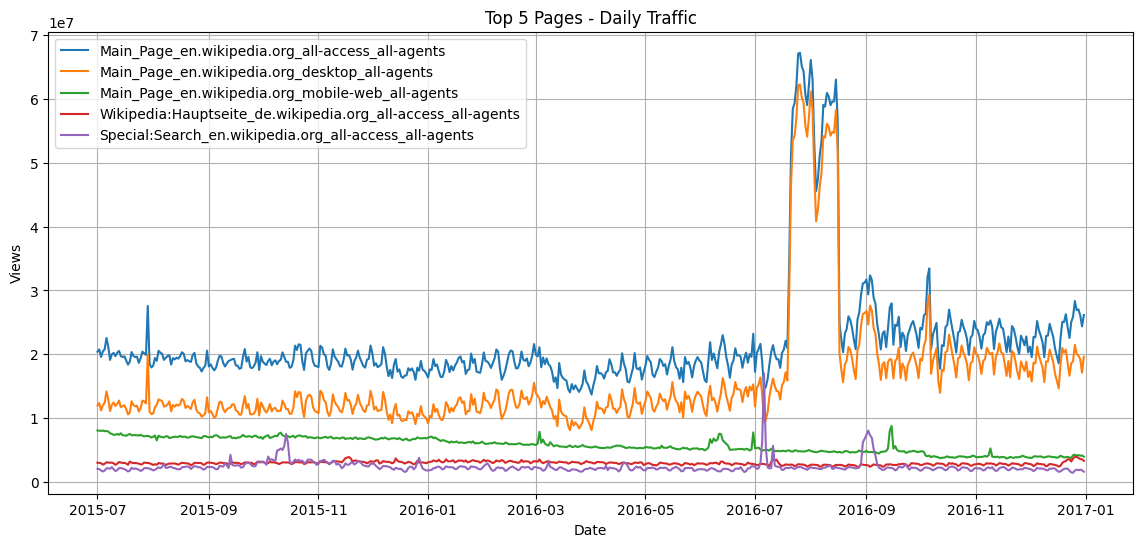

In [28]:
top_pages = total_views.head(5).index.tolist()

plt.figure(figsize = (14,6))
for page in top_pages:
    pages = train_1_long[train_1_long['Page'] == page]
    plt.plot(pages['Date'], pages['Views'], label = page)

plt.legend()
plt.title('Top 5 Pages - Daily Traffic')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.show()

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load preprocessed data
df = pd.read_csv("train_1_preprocessed.csv")
df['Date'] = pd.to_datetime(df['Date'])




In [57]:
# Pick one Wikipedia page with high traffic for training
top_page = 'Barack_Obama_en.wikipedia.org_all-access_all-agents'
print("Selected Page:", top_page)

page_df = df[df['Page'] == top_page].sort_values('Date').reset_index(drop=True)

# Compute time-based features on page_df
page_df['Weekday'] = page_df['Date'].dt.weekday         # Monday=0, Sunday=6
page_df['Month'] = page_df['Date'].dt.month               # 1 to 12

# Normalize these features to [0,1]
page_df['Weekday_norm'] = page_df['Weekday'] / 6.0
page_df['Month_norm'] = (page_df['Month'] - 1) / 11.0

# Check first few rows to confirm
print(page_df.head())


Selected Page: Barack_Obama_en.wikipedia.org_all-access_all-agents
                                                Page       Article  \
0  Barack_Obama_en.wikipedia.org_all-access_all-a...  Barack_Obama   
1  Barack_Obama_en.wikipedia.org_all-access_all-a...  Barack_Obama   
2  Barack_Obama_en.wikipedia.org_all-access_all-a...  Barack_Obama   
3  Barack_Obama_en.wikipedia.org_all-access_all-a...  Barack_Obama   
4  Barack_Obama_en.wikipedia.org_all-access_all-a...  Barack_Obama   

           Language      Access       Agent       Date    Views  Weekday  \
0  en.wikipedia.org  all-access  all-agents 2015-07-01  28422.0        2   
1  en.wikipedia.org  all-access  all-agents 2015-07-02  26087.0        3   
2  en.wikipedia.org  all-access  all-agents 2015-07-03  25254.0        4   
3  en.wikipedia.org  all-access  all-agents 2015-07-04  25659.0        5   
4  en.wikipedia.org  all-access  all-agents 2015-07-05  25946.0        6   

   Month  Weekday_norm  Month_norm  
0      7      0.33

In [66]:
from sklearn.preprocessing import MinMaxScaler

# Extract the 'Views' column and reshape it for scaling
views = page_df['Views'].values.reshape(-1, 1)

# Apply log transform to stabilize large spikes
views_log = np.log1p(views)

# Now scale the log-transformed views
scaler = MinMaxScaler()
views_scaled = scaler.fit_transform(views_log)

# Extract the normalized weekday and month features
weekdays = page_df['Weekday_norm'].values.reshape(-1, 1)
months = page_df['Month_norm'].values.reshape(-1, 1)

# Combine features: each row is [scaled_views, weekday_norm, month_norm]
features = np.concatenate((views_scaled, weekdays, months), axis=1)


In [67]:
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        # The target is the next day's view (first feature)
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

# Set window size to 60 (experiment with 30 if needed)
window_size = 60
X, y = create_sequences(features, window_size)

print("Shape of X:", X.shape)  # Expected: (samples, window_size, 3)
print("Shape of y:", y.shape)

# Split into training and testing sets (80/20 split)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


Shape of X: (490, 60, 3)
Shape of y: (490,)


In [68]:
# Build a more complex LSTM model
model = Sequential()
# First LSTM layer with 128 units, return sequences for stacking
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.3))
# Second LSTM layer with 64 units, still returning sequences
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
# Third LSTM layer with 32 units (final sequence output)
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
# Output Dense layer
model.add(Dense(1))

# Use Adam optimizer with a reduced learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Train the model for more epochs (e.g., 100 epochs)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100
11/11 [==============================] - 3s 74ms/step - loss: 0.0177 - val_loss: 0.0049
Epoch 2/100
11/11 [==============================] - 0s 45ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 3/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 4/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 5/100
11/11 [==============================] - 0s 44ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 6/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 7/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 8/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 9/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/100
11/11 [==============================] - 0s 43ms/step - loss: 0.0054 - val_loss: 0.0047

In [69]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and true values (for the Views column)
y_pred_inv = scaler_views.inverse_transform(y_pred)
y_test_inv = scaler_views.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for the LSTM model
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM RMSE:", rmse_lstm)

# Baseline: Naive forecast using the last value in each test sequence
y_baseline = np.array([seq[-1, 0] for seq in X_test]).reshape(-1, 1)
y_baseline_inv = scaler_views.inverse_transform(y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_inv, y_baseline_inv))
print("Baseline RMSE:", rmse_baseline)


4/4 [==============================] - 0s 14ms/step
LSTM RMSE: 157382.7675161242
Baseline RMSE: 53765.44456950215


In [70]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and true values (for the Views column)
y_pred_inv = scaler_views.inverse_transform(y_pred)
y_test_inv = scaler_views.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for the LSTM model
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM RMSE:", rmse_lstm)

# Baseline: Naive forecast using the last value in each test sequence
y_baseline = np.array([seq[-1, 0] for seq in X_test]).reshape(-1, 1)
y_baseline_inv = scaler_views.inverse_transform(y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_inv, y_baseline_inv))
print("Baseline RMSE:", rmse_baseline)


4/4 [==============================] - 0s 16ms/step
LSTM RMSE: 157382.7675161242
Baseline RMSE: 53765.44456950215


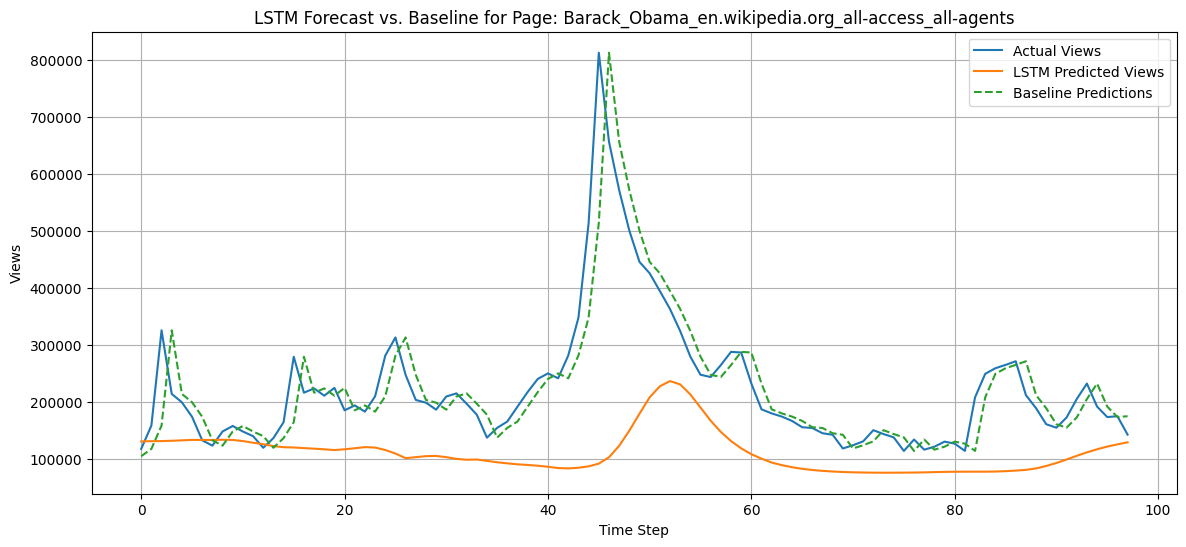

In [71]:
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Views')
plt.plot(y_pred_inv, label='LSTM Predicted Views')
plt.plot(y_baseline_inv, label='Baseline Predictions', linestyle='--')
plt.title(f"LSTM Forecast vs. Baseline for Page: {top_page}")
plt.xlabel("Time Step")
plt.ylabel("Views")
plt.legend()
plt.grid()
plt.show()


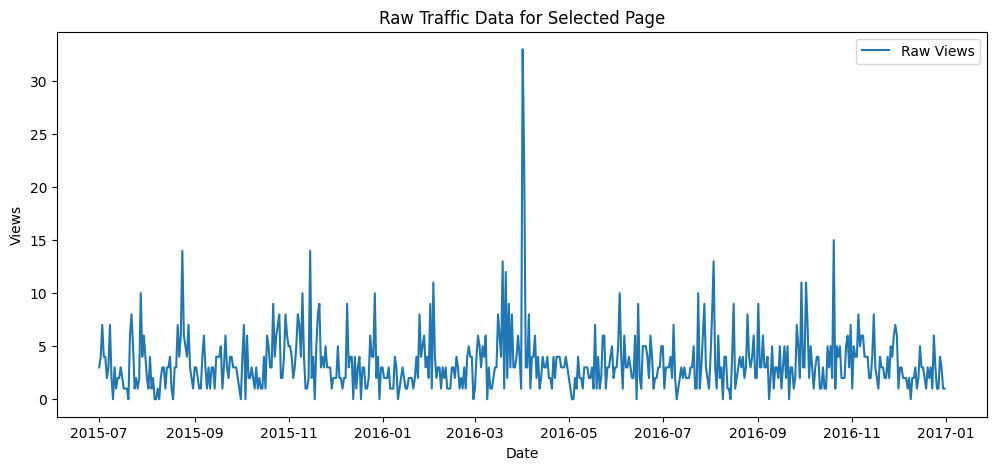

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(page_df['Date'], page_df['Views'], label='Raw Views')
plt.title("Raw Traffic Data for Selected Page")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.show()


Preprocessed data loaded. Shape: (79784650, 7)
Selected Page for LSTM model: Main_Page_en.wikipedia.org_all-access_all-agents
Records for selected page: 550
                                               Page    Article  \
0  Main_Page_en.wikipedia.org_all-access_all-agents  Main_Page   
1  Main_Page_en.wikipedia.org_all-access_all-agents  Main_Page   
2  Main_Page_en.wikipedia.org_all-access_all-agents  Main_Page   
3  Main_Page_en.wikipedia.org_all-access_all-agents  Main_Page   
4  Main_Page_en.wikipedia.org_all-access_all-agents  Main_Page   

           Language      Access       Agent       Date       Views  
0  en.wikipedia.org  all-access  all-agents 2015-07-01  20381245.0  
1  en.wikipedia.org  all-access  all-agents 2015-07-02  20752194.0  
2  en.wikipedia.org  all-access  all-agents 2015-07-03  19573967.0  
3  en.wikipedia.org  all-access  all-agents 2015-07-04  20439645.0  
4  en.wikipedia.org  all-access  all-agents 2015-07-05  20772109.0  


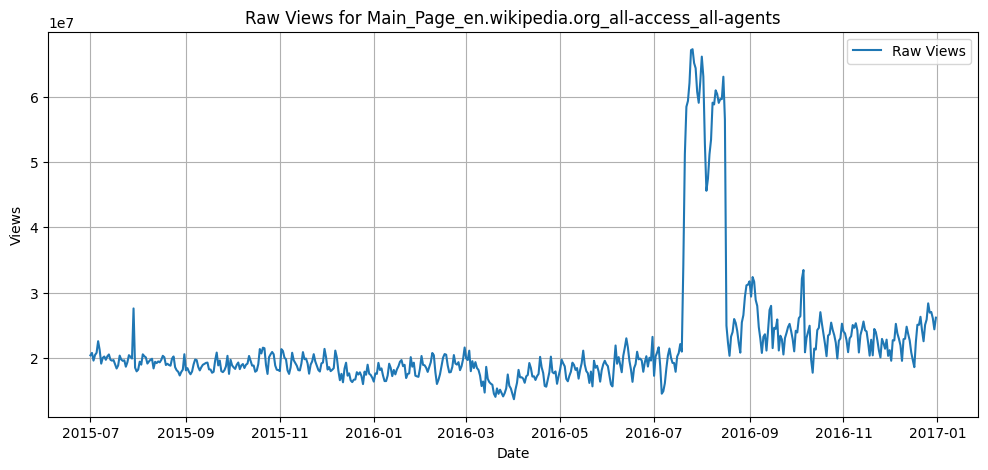

Features shape: (550, 2)
Shape of X: (520, 30, 2)
Shape of y: (520,)
Training samples: 416 Testing samples: 104
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 30, 128)           67072     
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 30, 64)            49408     
                                                                 
 dropout_16 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
        

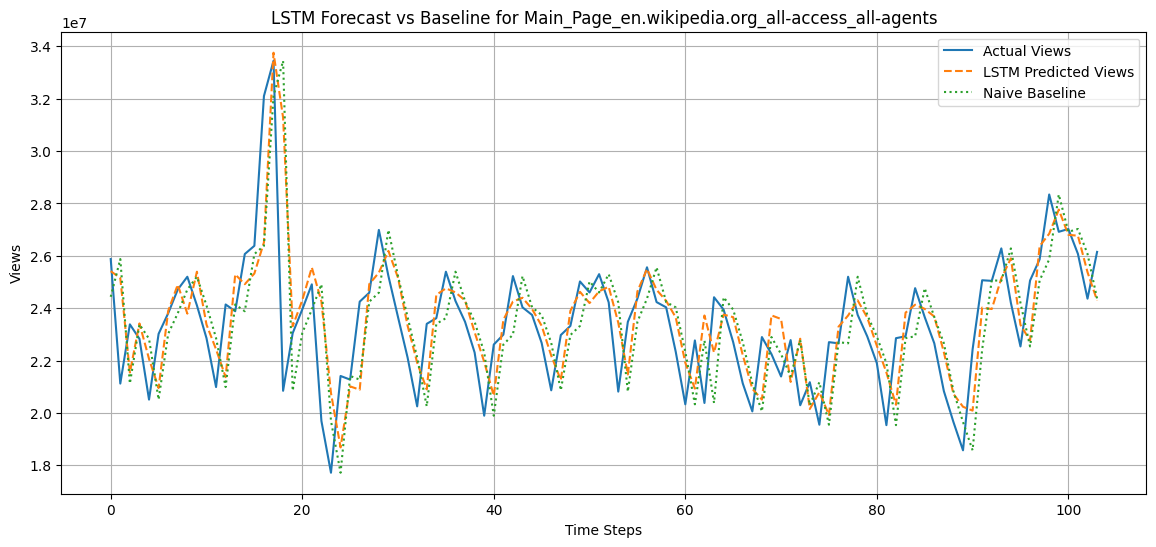

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# =======================================================
# PART 1: Load Preprocessed Data
# =======================================================
# Assuming "train_1_preprocessed.csv" is in your current working directory
df = pd.read_csv("train_1_preprocessed.csv")
df['Date'] = pd.to_datetime(df['Date'])
print("Preprocessed data loaded. Shape:", df.shape)

# =======================================================
# PART 2: Select a Representative Page
# =======================================================
# Select one page based on total views (or choose manually)
total_views = df.groupby('Page')['Views'].sum().sort_values(ascending=False)
top_pages = total_views.head(5).index.tolist()  # top 5 pages
selected_page = top_pages[0]  # choose the first one; modify as needed
print("Selected Page for LSTM model:", selected_page)

# Filter data for the selected page and sort by Date
page_df = df[df['Page'] == selected_page].sort_values('Date').reset_index(drop=True)
print("Records for selected page:", len(page_df))
print(page_df.head())

# (Optional) Plot raw views to inspect variability
plt.figure(figsize=(12,5))
plt.plot(page_df['Date'], page_df['Views'], label='Raw Views')
plt.title(f"Raw Views for {selected_page}")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.show()

# =======================================================
# PART 3: Feature Engineering
# =======================================================
# We add an extra time-based feature: weekday (normalized)
page_df['Weekday'] = page_df['Date'].dt.weekday  # Monday=0, ... Sunday=6
page_df['Weekday_norm'] = page_df['Weekday'] / 6.0

# =======================================================
# PART 4: Prepare the Feature Matrix & Create Sequences
# =======================================================
# Use the "Views" column with a log transformation.
views = page_df['Views'].values.reshape(-1, 1)
views_log = np.log1p(views)  # log transform to stabilize variance

# Scale the log-transformed views to [0, 1]
scaler = MinMaxScaler()
views_scaled = scaler.fit_transform(views_log)

# Include the normalized weekday as an additional feature.
weekdays = page_df['Weekday_norm'].values.reshape(-1, 1)

# Combine features: each row is [log-transformed views, weekday_norm]
features = np.concatenate((views_scaled, weekdays), axis=1)
print("Features shape:", features.shape)

# Define a function to create sliding window sequences.
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        # Use only the first feature (log-transformed views) as the target
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

# Set window size (e.g., 30 days) and create sequences.
window_size = 30
X, y = create_sequences(features, window_size)
print("Shape of X:", X.shape)  # Expected: (samples, window_size, 2)
print("Shape of y:", y.shape)

# Split the data into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print("Training samples:", len(X_train), "Testing samples:", len(X_test))

# =======================================================
# PART 5: Build and Train the LSTM Model
# =======================================================
model = Sequential()
# First LSTM layer with 128 units; returns sequences for stacking layers.
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.01))  # reduced dropout to allow more fit
# Second LSTM layer with 64 units; returns sequences.
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.01))
# Third LSTM layer with 32 units (final LSTM layer).
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.0))
# Output Dense layer for regression.
model.add(Dense(1))

# Use Adam optimizer with a learning rate of 0.004.
optimizer = Adam(learning_rate=0.004)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# Train the model for 150 epochs with a batch size of 32.
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1)

# =======================================================
# PART 6: Evaluate the Model and Compare with a Naive Baseline
# =======================================================
# Predict on the test set.
y_pred = model.predict(X_test)

# Inverse-transform predictions and actual targets to the original log-transformed scale.
y_pred_inv_log = scaler.inverse_transform(y_pred)
y_test_inv_log = scaler.inverse_transform(y_test.reshape(-1, 1))

# Convert back from log scale to original view scale.
y_pred_inv = np.expm1(y_pred_inv_log)
y_test_inv = np.expm1(y_test_inv_log)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM RMSE:", rmse)

# Naive baseline: use the last value of each test sequence as the prediction.
y_baseline = np.array([seq[-1, 0] for seq in X_test]).reshape(-1, 1)
y_baseline_inv_log = scaler.inverse_transform(y_baseline)
y_baseline_inv = np.expm1(y_baseline_inv_log)

rmse_baseline = np.sqrt(mean_squared_error(y_test_inv, y_baseline_inv))
print("Naive Baseline RMSE:", rmse_baseline)

# =======================================================
# PART 7: Plot the Results
# =======================================================
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Views')
plt.plot(y_pred_inv, label='LSTM Predicted Views', linestyle='--')
plt.plot(y_baseline_inv, label='Naive Baseline', linestyle=':')
plt.title(f"LSTM Forecast vs Baseline for {selected_page}")
plt.xlabel("Time Steps")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.show()
